### This notebook contains scripts that plot the Cryosat-2 waveform from L1B SARIn product.
Data Input: netcdf files obtained from http://science-pds.cryosat.esa.int

parameters required for plotting the waveform are only available in L1B

Lat/lon are informed by homogeneous ice patches identified from SAR imagery by John Y.

s
Created July 13, 2025 by Hoi Ming Lam

In [ ]:
import xarray as xr
import numpy as np
import netCDF4 as nc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [ ]:
def points_within_bounding_box(points, bbox):
    """
    Filters points within a bounding box.
    
    Args:
        points (list of tuples): List of (latitude, longitude) tuples.
        bbox (tuple): Bounding box as (min_lat, min_lon, max_lat, max_lon).
        
    Returns:
        list of tuples: Points within the bounding box.
    """
    
    min_lat, min_lon, max_lat, max_lon = bbox

    inside_points = [
        (lat, lon) for lat, lon in points
        if min_lat <= lat <= max_lat and min_lon <= lon <= max_lon
    ]
    # return [i for i in range(len(lat)) if (lat[i], lon[i]) in inside_points]
    return inside_points

In [ ]:
def plot_wfm(ds, i, bin_start=0, bin_end=1024, ylim=None, ax=None):

    """
    This function plots a single waveform.
    You can set bin_start and bin_end to "zoom" in on part of the x-axis 
    (e.g. usually the main waveform is roughly between 200 and 500) 
    """
    
    waveforms = ds.variables['pwr_waveform_20_ku'][:]  # Power waveforms for 20 Hz
    echo_scale_pwr = ds.variables['echo_scale_pwr_20_ku'][:]  # Scaling factor for power
    echo_scale_factor = ds.variables['echo_scale_factor_20_ku'][:]  # Scaling factor exponent
    latitudes = ds.variables['lat_20_ku'][:]  # Latitude (20 Hz)
    longitudes = ds.variables['lon_20_ku'][:]  # Longitude (20 Hz)
    time = ds.variables['time_20_ku'][:]  # Ti

    
    # Apply scaling to convert waveforms to power in watts
    scaled_waveform = waveforms * echo_scale_factor * (2.0 ** echo_scale_pwr)

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(scaled_waveform[i, bin_start:bin_end], color='red') #, label=f"Lat: {latitudes[min_index]:.4f}, Lon: {longitudes[min_index]:.4f}")
    
    ax.set_title(time[i].values)
    ax.set_xlabel("Range Gate")
    ticks = np.arange(bin_start, bin_end+1, 20)  # from 270 to 450 with step 10

    ax.axvline(300-bin_start, color='k', ls='--', lw=1, alpha=0.7, zorder=0)

    # Replace x-ticks (1 to 10) with 270 to 450 labels
    ax.set_xticks(ticks=ticks-bin_start, labels=ticks)
    ax.set_ylabel("Power (Watts)")
    if ylim==None:
        ylim = scaled_waveform.max()*1.1
    ax.set_ylim(0, ylim)
    ax.grid(alpha=0.7, zorder=0)      
    plt.tight_layout()
    # plt.show()
    return ax


In [ ]:
def plot_wfm_all(ds, bin_start=0, bin_end=1024, ylim=None, ax=None):
    """
    This function plots all waveforms along the input track.
    You can set bin_start and bin_end to "zoom" in on part of the x-axis 
    (e.g. usually the main waveform is roughly between 200 and 500) 
    """
    
    waveforms = ds.variables['pwr_waveform_20_ku'][:]  # Power waveforms for 20 Hz
    echo_scale_pwr = ds.variables['echo_scale_pwr_20_ku'][:]  # Scaling factor for power
    echo_scale_factor = ds.variables['echo_scale_factor_20_ku'][:]  # Scaling factor exponent
    latitudes = ds.variables['lat_20_ku'][:]  # Latitude (20 Hz)
    longitudes = ds.variables['lon_20_ku'][:]  # Longitude (20 Hz)
    time = ds.variables['time_20_ku'][:]  # Ti

    scaled_waveform = waveforms * echo_scale_factor * (2.0 ** echo_scale_pwr)

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))

    n_to_plot = len(ds.rec_count_20_ku)
    print(n_to_plot)
    
    # Generate a colormap with n_lines colors
    cmap = plt.colormaps['viridis']  # or matplotlib.colormaps.get_cmap('viridis')
    
    # Create a ScalarMappable with a normalized range
    norm = mcolors.Normalize(vmin=0, vmax=n_to_plot - 1)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
      
    # ylim = 1.5e-12#10e-13
    for i in range(n_to_plot):   
        ax.plot(scaled_waveform[i, bin_start:bin_end], color=cmap(norm(i))) #, label=f"Lat: {latitudes[min_index]:.4f}, Lon: {longitudes[min_index]:.4f}")

        print(str(time[i].values))
        
    ax.set_title(str(time[i].values)[:10])
    ax.set_xlabel("Range Gate")
    ticks = np.arange(bin_start, bin_end+1, 20)  # from 270 to 450 with step 10
    # custom_labels = list(range(bin_start, bin_end, int((bin_end - bin_start) / (len(scaled_waveform[i, bin_start:bin_end]) - 1))))
    ax.axvline(300-bin_start, color='k', ls='--', lw=1, alpha=0.7, zorder=0)
    
    # Replace x-ticks (1 to 10) with 270 to 450 labels
    ax.set_xticks(ticks=ticks-bin_start, labels=ticks)
    ax.set_ylabel("Power (Watts)")
    if ylim==None:
        ylim = scaled_waveform.max()*1.1

    # add colorbar showing the line indices
    cbar = plt.colorbar(sm, ax=ax, ticks=range(n_to_plot))
    cbar.set_ticklabels(time.values)#)
    # cbar.set_label('Index')  
    
    ax.set_ylim(0, ylim)
    ax.grid(alpha=0.7, zorder=0)      
    plt.tight_layout()
    # plt.show()
    return ax


In [ ]:
def plot_wfm_mean(ds, bin_start=0, bin_end=1024, ylim=None, ax=None):
    """
    This function plots the mean and standard deviation of all waveforms along the input track.
    You can set bin_start and bin_end to "zoom" in on part of the x-axis 
    (e.g. usually the main waveform is roughly between 200 and 500) 
    """
    
    waveforms = ds.variables['pwr_waveform_20_ku'][:]  # Power waveforms for 20 Hz
    echo_scale_pwr = ds.variables['echo_scale_pwr_20_ku'][:]  # Scaling factor for power
    echo_scale_factor = ds.variables['echo_scale_factor_20_ku'][:]  # Scaling factor exponent
    latitudes = ds.variables['lat_20_ku'][:]  # Latitude (20 Hz)
    longitudes = ds.variables['lon_20_ku'][:]  # Longitude (20 Hz)
    time = ds.variables['time_20_ku'][:]  # Ti

    scaled_waveform = waveforms * echo_scale_factor * (2.0 ** echo_scale_pwr)

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))

    n_to_plot = len(ds.rec_count_20_ku)
    
    # Calculate mean and std
    mean_waveform = np.mean(scaled_waveform, axis=0)
    std_waveform = np.std(scaled_waveform, axis=0)

    # Create axis if none provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))

    # Plot
    bins = np.arange(bin_start, bin_end)
    ax.plot(bins, mean_waveform[bin_start:bin_end], label='Mean waveform', color='red', lw=2)
    ax.fill_between(bins, mean_waveform[bin_start:bin_end] - std_waveform[bin_start:bin_end],
                    mean_waveform[bin_start:bin_end] + std_waveform[bin_start:bin_end],
                    color='gray', alpha=0.3, label='±1 Std Dev')

    ax.set_xlabel("Range Gate")
    ax.set_ylabel("Power (Watts)")

    ax.grid(True)
    if ylim==None:
        ylim = mean_waveform[bin_start:bin_end].max()*1.9
    ax.set_ylim(0, ylim)
    ax.legend()

    return ax


### The following is based on the thin and thick cases identified near Eureka in 2024.

The thin case is 2024-04-11 (cold) and 2024-05-22 (warm)

The thick case is 2024-04-06 (cold) and 2024-05-19 (warm)

### Run the next box. Enter 'thin' or 'thick' in the prompt.

It will read the corresponding files and store them as ds1_bbox (cold) and ds2_bbox (warm)

In [191]:
choice = input("Enter 'thin' or 'thick': ").strip().lower()

if choice == "thin":
    # --- Thin code block ---
    print("Running thin code...")
    # THIN CASE
    # Load both subsetted datasets
    ds1 = xr.open_dataset("subset_CS_OFFL_SIR_SIN_1B_20240411T105309_20240411T105755_E001.nc")
    ds2 = xr.open_dataset("subset_CS_OFFL_SIR_SIN_1B_20240522T191214_20240522T191615_E001.nc")
    
    # Extract lat, lon, and time
    lat1, lon1, time1 = ds1["lat_20_ku"].values, ds1["lon_20_ku"].values, ds1["time_20_ku"].values
    lat2, lon2, time2 = ds2["lat_20_ku"].values, ds2["lon_20_ku"].values, ds2["time_20_ku"].values
    
    # Round lat/lon for intersection tolerance (adjust decimal as needed)
    decimals = 99
    coords1 = set(zip(lat1, lon1))
    coords2 = set(zip(lat2, lon2))
    
    bbox = (80.237, -87.015, 80.299,  -86.794)
    
    inside1 = points_within_bounding_box(coords1, bbox)
    inside2 = points_within_bounding_box(coords2, bbox)
    
    # Get corresponding time values
    
    ds1.close()
    ds2.close
    
    ### Jul 13, 2025
    # THIN
    ### Dropping by rec_count_20_ku, check that lat/lon start/end are correct
    ds1_bbox_tmp = ds1.where(ds1.rec_count_20_ku>=ds1.rec_count_20_ku.values.min()+33, drop=True) # thick case 20240406 start 1 80.148 -97.050 end 32 80.066 -97.157
    ds1_bbox = ds1_bbox_tmp.where(ds1_bbox_tmp.rec_count_20_ku<=ds1_bbox_tmp.rec_count_20_ku.values.min()+57-34, drop=True) # thick case 20240406 start 1 80.148 -97.050 end 32 80.066 -97.157
    # ds1_bbox['lon_20_ku']
    
    # ds2.where(ds2.rec_count_20_ku<=523, drop=True)
    ds2_tmp = ds2.where(ds2.rec_count_20_ku<=ds2.rec_count_20_ku.values.min()+59, drop=True) # thick case 20240519 start 93 80.052 -97.464 end 126 80.139 -97.577
    ds2_bbox = ds2_tmp.where(ds2_tmp.rec_count_20_ku>=ds2.rec_count_20_ku.values.min()+36, drop=True) 
    print('done - thin')

elif choice == "thick":
    # --- Thick code block ---
    print("Running thick code...")
    ### Added July 13, 2025
    # THICK CASE
    
    # Load both subsetted datasets
    ds1 = xr.open_dataset("subset_CS_OFFL_SIR_SIN_1B_20240406T114803_20240406T115232_E001.nc")
    ds2 = xr.open_dataset("subset_CS_OFFL_SIR_SIN_1B_20240519T200408_20240519T200815_E001.nc")
    
    # Extract lat, lon, and time
    lat1, lon1, time1 = ds1["lat_20_ku"].values, ds1["lon_20_ku"].values, ds1["time_20_ku"].values
    lat2, lon2, time2 = ds2["lat_20_ku"].values, ds2["lon_20_ku"].values, ds2["time_20_ku"].values
    
    # Round lat/lon for intersection tolerance (adjust decimal as needed)
    decimals = 99
    coords1 = set(zip(lat1, lon1))
    coords2 = set(zip(lat2, lon2))
    
    bbox = (80.052, -97.577, 80.148,  -97.050)
    
    inside1 = points_within_bounding_box(coords1, bbox)
    inside2 = points_within_bounding_box(coords2, bbox)
    
    # Get corresponding time values
    
    ds1.close()
    ds2.close()
    
    ### Jul 13, 2025
    # THICK
    ### Dropping by rec_count_20_ku, check that lat/lon start/end are correct
    ds1_bbox = ds1.where(ds1.rec_count_20_ku<=524, drop=True) # thick case 20240406 start 1 80.148 -97.050 end 32 80.066 -97.157
    
    # ds2.where(ds2.rec_count_20_ku<=523, drop=True)
    ds2_tmp = ds2.where(ds2.rec_count_20_ku<=ds2.rec_count_20_ku.values.min()+125, drop=True) # thick case 20240519 start 93 80.052 -97.464 end 126 80.139 -97.577
    ds2_bbox = ds2_tmp.where(ds2_tmp.rec_count_20_ku>=ds2.rec_count_20_ku.values.min()+92, drop=True) 

    print('done - thick')
else:
    print("Invalid input. Please enter 'thin' or 'thick'.")


Enter 'thin' or 'thick':  thin


Running thin code...
done - thin


In [ ]:
plt.close('all')


### For the thin case, run the following.

In [ ]:
# plot_wfm_all(ds1_bbox, bin_start=230, bin_end=410)
plot_wfm_all(ds1_bbox, bin_start=230, bin_end=410, ylim=1.5e-12)
# plt.savefig('thick_20240406.png')
# plt.savefig('thick_20240406_ylim.png')
# plt.savefig('thin_20240411.png')
plt.savefig('thin_20240411_ylim.png')

plot_wfm_mean(ds1_bbox, bin_start=230, bin_end=410, ylim=5e-13)
plt.savefig('thin_20240411_mean.png')

In [ ]:
# plot_wfm_all(ds2_bbox, bin_start=230, bin_end=410)
plot_wfm_all(ds2_bbox, bin_start=230, bin_end=410, ylim=1.5e-12)
# plt.savefig('thick_20240519.png')
# plt.savefig('thick_20240519_ylim.png')
# plt.savefig('thin_20240522.png')
plt.savefig('thin_20240522_ylim.png')


plot_wfm_mean(ds2_bbox, bin_start=230, bin_end=410, ylim=5e-13)
plt.savefig('thin_20240522_mean.png')


### For the thick case, run the following.

34
2024-04-06T11:49:01.806257920
2024-04-06T11:49:01.851446016
2024-04-06T11:49:01.896633984
2024-04-06T11:49:01.941822080
2024-04-06T11:49:01.987010048
2024-04-06T11:49:02.032198016
2024-04-06T11:49:02.077385984
2024-04-06T11:49:02.122573952
2024-04-06T11:49:02.167762048
2024-04-06T11:49:02.212950016
2024-04-06T11:49:02.258137984
2024-04-06T11:49:02.303325952
2024-04-06T11:49:02.348513920
2024-04-06T11:49:02.393702016
2024-04-06T11:49:02.438889984
2024-04-06T11:49:02.484078080
2024-04-06T11:49:02.529266048
2024-04-06T11:49:02.574453888
2024-04-06T11:49:02.619641984
2024-04-06T11:49:02.664829952
2024-04-06T11:49:02.710018048
2024-04-06T11:49:02.755206016
2024-04-06T11:49:02.800394112
2024-04-06T11:49:02.845581952
2024-04-06T11:49:02.890769920
2024-04-06T11:49:02.935958016
2024-04-06T11:49:02.981145984
2024-04-06T11:49:03.026332928
2024-04-06T11:49:03.071521024
2024-04-06T11:49:03.116708992
2024-04-06T11:49:03.161896960
2024-04-06T11:49:03.207083904
2024-04-06T11:49:03.252271104
2024-04

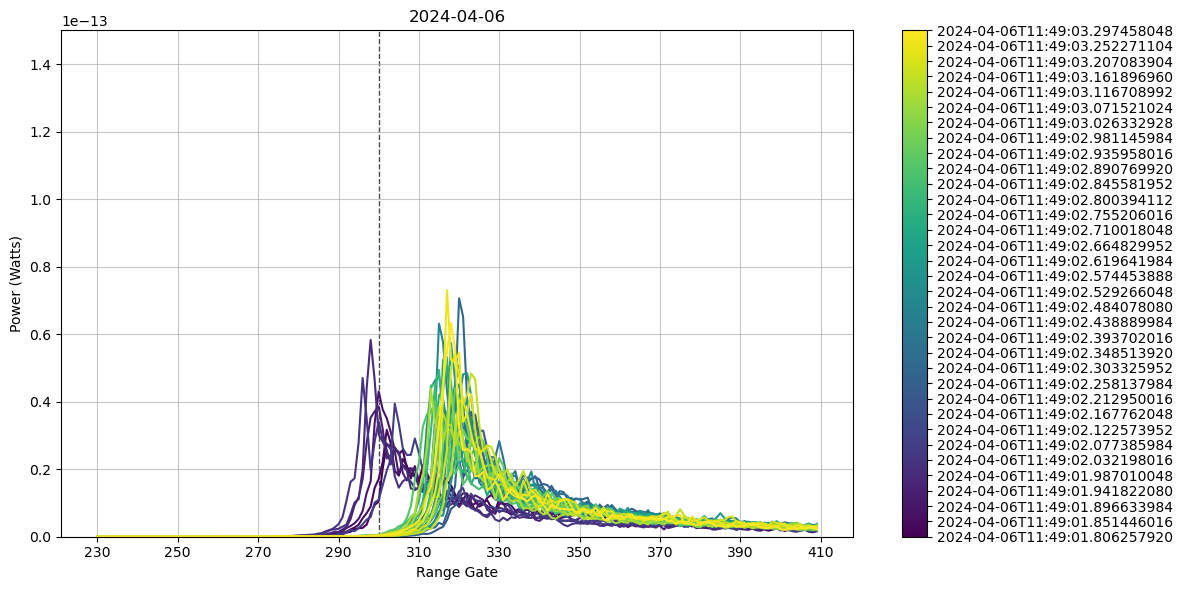

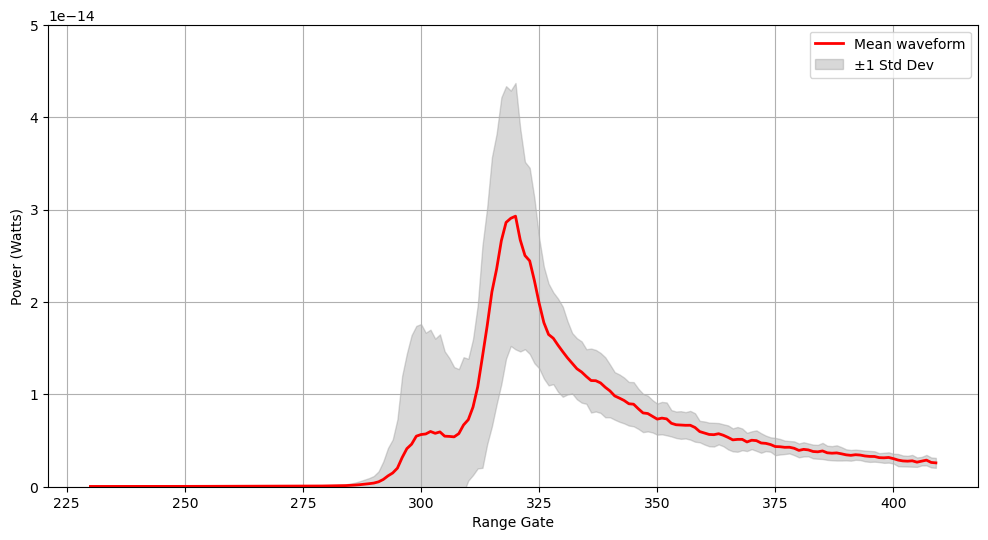

In [35]:
plot_wfm_all(ds1_bbox, bin_start=230, bin_end=410, ylim=1.5e-13)
plt.savefig('thick_20240406_ylim.png')

plot_wfm_mean(ds1_bbox, bin_start=230, bin_end=410, ylim=5e-14)
plt.savefig('thick_20240406_mean.png')


In [ ]:
# plot_wfm_all(ds2_bbox, bin_start=230, bin_end=410)
plot_wfm_all(ds2_bbox, bin_start=230, bin_end=410, ylim=1.5e-13)
# plt.savefig('thick_20240519.png')
plt.savefig('thick_20240519_ylim.png')
# plt.savefig('thin_20240522.png')
# plt.savefig('thin_20240522_ylim.png')

plot_wfm_mean(ds2_bbox, bin_start=230, bin_end=410, ylim=5e-14)
plt.savefig('thick_20240519_mean.png')

In [ ]:
ds1_bbox.info()

### November 1, 2025
Window delay
Shifting the individual waveformsin the range bin axis using the window delay parameter (window_del_20_ku)
First, calculate the difference between window delay of each measurement and its mean across the input track (subsection). This will be in unit second.
Then, calculate the equivalent amount of range bin of the differences. Each range bin covers a time of 1.5625 ns one-way
Finally, add this shift to the waveform plots


In [143]:
# Adjust for shift in window delay
window_del_diff = ds1_bbox["window_del_20_ku"] - ds1_bbox["window_del_20_ku"].mean()

bin_time = 1.5625 #ns
# Number of range bin shift 
rng_shft = window_del_diff / bin_time
rng_shft = rng_shft.astype(np.int64)


In [ ]:
# Adjust for shift in altitude
alt_diff = ds1_bbox["alt_20_ku"] - ds1_bbox["alt_20_ku"].mean()

bin_dist = 0.2342*2#m
# Number of range bin shift 
alt_shft = alt_diff / bin_dist
alt_shft.round() #= rng_shft.astype(np.int64)


In [188]:
def plot_wfm_rng_adjst(ds, bin_start=0, bin_end=1024, ylim=None, ax=None):
    """
    This function plots all waveforms along the input track
    Each waveform is adjusted in the range bin axis by......
    You can set bin_start and bin_end to "zoom" in on part of the x-axis 
    (e.g. usually the main waveform is roughly between 200 and 500) 
    """
    
    waveforms = ds.variables['pwr_waveform_20_ku'][:]  # Power waveforms for 20 Hz
    echo_scale_pwr = ds.variables['echo_scale_pwr_20_ku'][:]  # Scaling factor for power
    echo_scale_factor = ds.variables['echo_scale_factor_20_ku'][:]  # Scaling factor exponent
    latitudes = ds.variables['lat_20_ku'][:]  # Latitude (20 Hz)
    longitudes = ds.variables['lon_20_ku'][:]  # Longitude (20 Hz)
    time = ds.variables['time_20_ku'][:]  # Ti
    window_delay = ds.variables['pwr_waveform_20_ku'][:]  # Power waveforms for 20 Hz

    scaled_waveform = waveforms * echo_scale_factor * (2.0 ** echo_scale_pwr)

    # Finding the difference between window delay and its mean along the input track (in second)
    window_del_diff = ds.variables["window_del_20_ku"][:] - ds.variables["window_del_20_ku"][:].mean()
    # Each sample bin covers a time delay of 1.5625 ns
    bin_time = 1.5625*2 # unit: ns; multiplied by 2 because of two-way time
    # bin_time = 3.125#e-9
    # Number of range bin shift 
    rng_shft = window_del_diff / bin_time
    rng_shft = rng_shft.astype(np.float64)

    alt_diff = ds.variables["alt_20_ku"][:] - ds.variables["alt_20_ku"][:].mean()
    bin_dist = 0.2342*2#m
    # Number of range bin shift 
    alt_shft = alt_diff / bin_dist
    alt_shft.round()
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))

    n_to_plot = len(ds.rec_count_20_ku)
    print(n_to_plot)
    
    # Generate a colormap with n_lines colors
    cmap = plt.colormaps['viridis']  # or matplotlib.colormaps.get_cmap('viridis')
    
    # Create a ScalarMappable with a normalized range
    norm = mcolors.Normalize(vmin=0, vmax=n_to_plot - 1)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
      
    # ylim = 1.5e-12#10e-13
    for i in range(n_to_plot):
        bin_num = ds['pwr_waveform_20_ku'][i]["ns_20_ku"]  # Power waveforms for 20 Hz
        
        ax.plot(bin_num[bin_start:bin_end] + rng_shft[i], scaled_waveform[i, bin_start:bin_end], color=cmap(norm(i))) #, label=f"Lat: {latitudes[min_index]:.4f}, Lon: {longitudes[min_index]:.4f}")

        print(str(time[i].values))
        
    ax.set_title(str(time[i].values)[:10])
    ax.set_xlabel("Range Gate")
    # ticks = np.arange(bin_start, bin_end+1, 20)   # from 270 to 450 with step 10
    # custom_labels = list(range(bin_start, bin_end, int((bin_end - bin_start) / (len(scaled_waveform[i, bin_start:bin_end]) - 1))))
    ax.axvline(300, color='k', ls='--', lw=2, alpha=0.8, zorder=0)
    
    # Replace x-ticks (1 to 10) with 270 to 450 labels
    # ax.set_xticks(ticks=ticks-bin_start, labels=ticks)
    ax.set_ylabel("Power (Watts)")
    if ylim==None:
        ylim = scaled_waveform.max()*1.1

    # add colorbar showing the line indices
    cbar = plt.colorbar(sm, ax=ax, ticks=range(n_to_plot))
    cbar.set_ticklabels(time.values)#)
    # cbar.set_label('Index')  
    
    ax.set_ylim(0, ylim)
    ax.grid(alpha=0.7, zorder=0)      
    plt.tight_layout()
    # plt.show()
    return ax


### Thin case

24
2024-04-11T10:54:35.451149952
2024-04-11T10:54:35.496296064
2024-04-11T10:54:35.541442048
2024-04-11T10:54:35.586587008
2024-04-11T10:54:35.631732992
2024-04-11T10:54:35.676879104
2024-04-11T10:54:35.722023936
2024-04-11T10:54:35.767169024
2024-04-11T10:54:35.812315008
2024-04-11T10:54:35.857460992
2024-04-11T10:54:35.902605952
2024-04-11T10:54:35.947751040
2024-04-11T10:54:35.992896000
2024-04-11T10:54:36.038040960
2024-04-11T10:54:36.083186048
2024-04-11T10:54:36.128331008
2024-04-11T10:54:36.173475968
2024-04-11T10:54:36.218621056
2024-04-11T10:54:36.263766016
2024-04-11T10:54:36.308910976
2024-04-11T10:54:36.354056960
2024-04-11T10:54:36.399202048
2024-04-11T10:54:36.444347008
2024-04-11T10:54:36.489492096


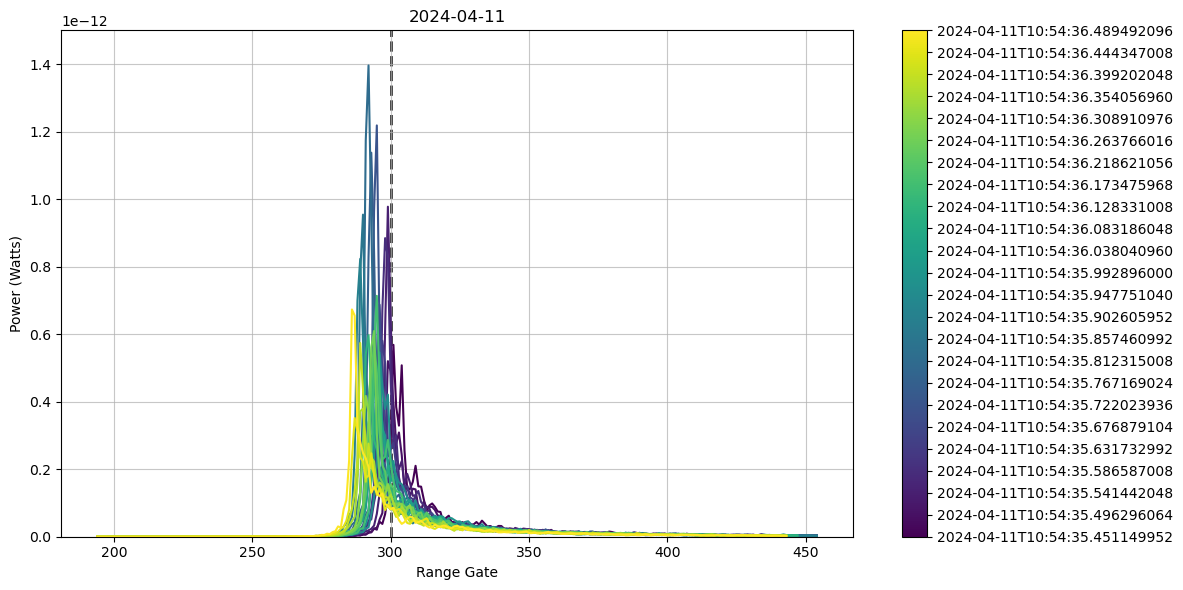

In [192]:
plot_wfm_rng_adjst(ds1_bbox, bin_start=200, bin_end=450, ylim=1.5e-12)
plt.savefig('thin_20240411_rng_shft.png')


24
2024-05-22T19:16:14.800227968
2024-05-22T19:16:14.845404032
2024-05-22T19:16:14.890583936
2024-05-22T19:16:14.935764992
2024-05-22T19:16:14.980945920
2024-05-22T19:16:15.026128000
2024-05-22T19:16:15.071308928
2024-05-22T19:16:15.116491008
2024-05-22T19:16:15.161675008
2024-05-22T19:16:15.206864000
2024-05-22T19:16:15.252055040
2024-05-22T19:16:15.297248000
2024-05-22T19:16:15.342440960
2024-05-22T19:16:15.387634944
2024-05-22T19:16:15.432829056
2024-05-22T19:16:15.478024064
2024-05-22T19:16:15.523218944
2024-05-22T19:16:15.568413952
2024-05-22T19:16:15.613608960
2024-05-22T19:16:15.658804096
2024-05-22T19:16:15.703999104
2024-05-22T19:16:15.749193984
2024-05-22T19:16:15.794388992
2024-05-22T19:16:15.839584000


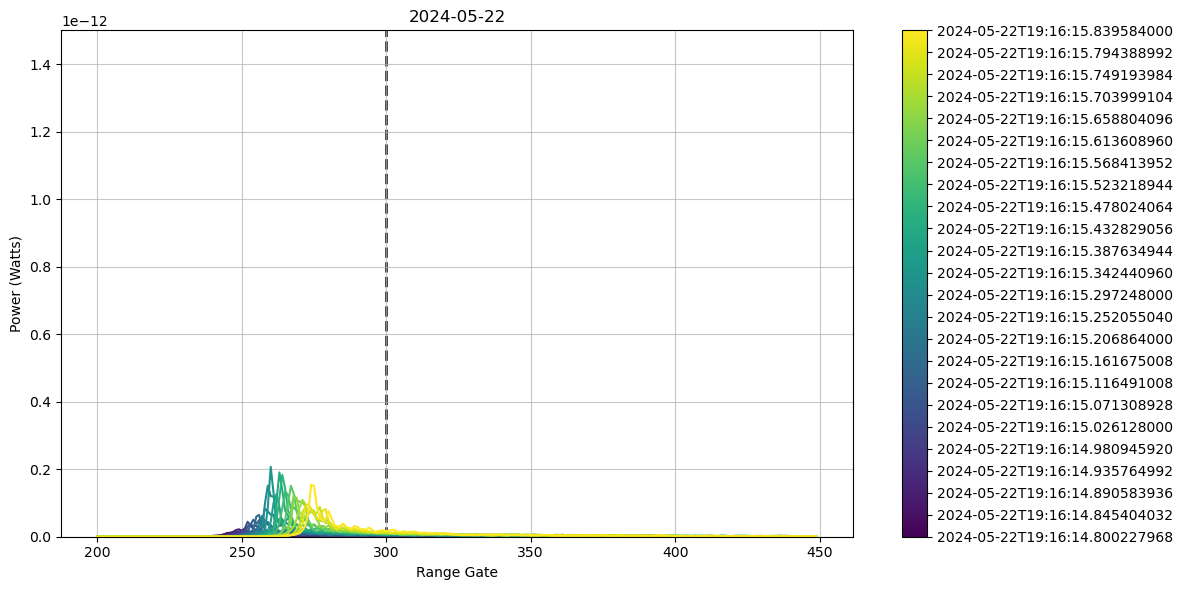

In [193]:
plot_wfm_rng_adjst(ds2_bbox, bin_start=200, bin_end=450, ylim=1.5e-12)
plt.savefig('thin_20240522_rng_shft.png')

### Thick case

34
2024-04-06T11:49:01.806257920
2024-04-06T11:49:01.851446016
2024-04-06T11:49:01.896633984
2024-04-06T11:49:01.941822080
2024-04-06T11:49:01.987010048
2024-04-06T11:49:02.032198016
2024-04-06T11:49:02.077385984
2024-04-06T11:49:02.122573952
2024-04-06T11:49:02.167762048
2024-04-06T11:49:02.212950016
2024-04-06T11:49:02.258137984
2024-04-06T11:49:02.303325952
2024-04-06T11:49:02.348513920
2024-04-06T11:49:02.393702016
2024-04-06T11:49:02.438889984
2024-04-06T11:49:02.484078080
2024-04-06T11:49:02.529266048
2024-04-06T11:49:02.574453888
2024-04-06T11:49:02.619641984
2024-04-06T11:49:02.664829952
2024-04-06T11:49:02.710018048
2024-04-06T11:49:02.755206016
2024-04-06T11:49:02.800394112
2024-04-06T11:49:02.845581952
2024-04-06T11:49:02.890769920
2024-04-06T11:49:02.935958016
2024-04-06T11:49:02.981145984
2024-04-06T11:49:03.026332928
2024-04-06T11:49:03.071521024
2024-04-06T11:49:03.116708992
2024-04-06T11:49:03.161896960
2024-04-06T11:49:03.207083904
2024-04-06T11:49:03.252271104
2024-04

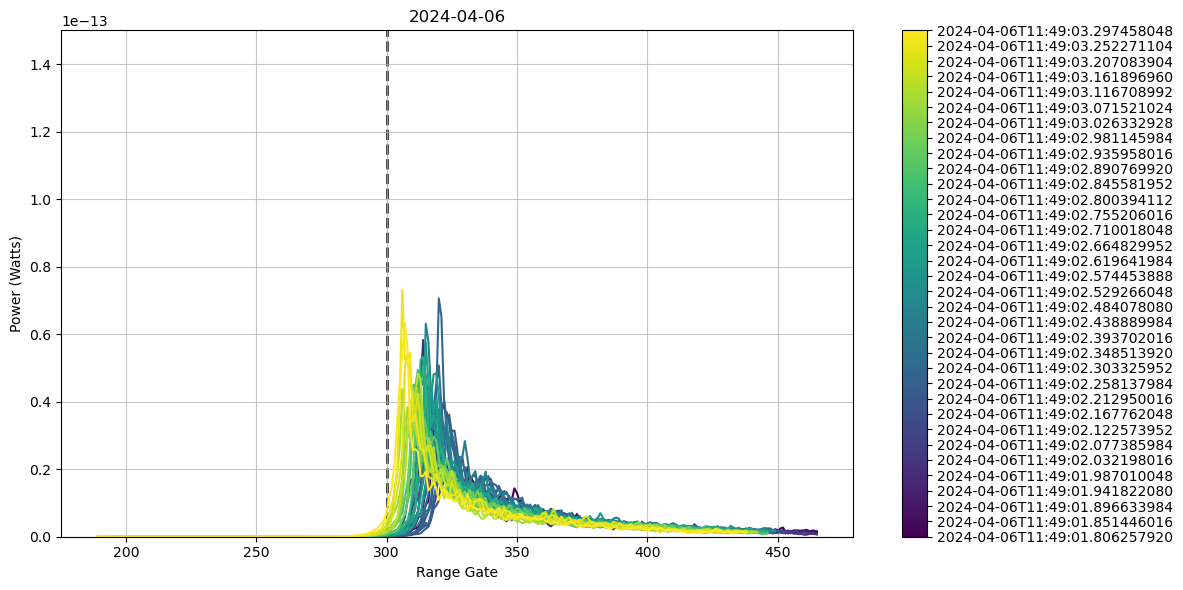

In [189]:
plot_wfm_rng_adjst(ds1_bbox, bin_start=200, bin_end=450, ylim=1.5e-13)
plt.savefig('thick_20240406_rng_shft.png')


34
2024-05-19T20:08:41.584781056
2024-05-19T20:08:41.629933056
2024-05-19T20:08:41.675084928
2024-05-19T20:08:41.720237056
2024-05-19T20:08:41.765388928
2024-05-19T20:08:41.810541056
2024-05-19T20:08:41.855692928
2024-05-19T20:08:41.900845056
2024-05-19T20:08:41.945997056
2024-05-19T20:08:41.991148928
2024-05-19T20:08:42.036301056
2024-05-19T20:08:42.081452928
2024-05-19T20:08:42.126605056
2024-05-19T20:08:42.171756928
2024-05-19T20:08:42.216909056
2024-05-19T20:08:42.262061952
2024-05-19T20:08:42.307214080
2024-05-19T20:08:42.352365952
2024-05-19T20:08:42.397518080
2024-05-19T20:08:42.442669952
2024-05-19T20:08:42.487822080
2024-05-19T20:08:42.532973952
2024-05-19T20:08:42.578125952
2024-05-19T20:08:42.623278080
2024-05-19T20:08:42.668429952
2024-05-19T20:08:42.713582976
2024-05-19T20:08:42.758736000
2024-05-19T20:08:42.803888000
2024-05-19T20:08:42.849040000
2024-05-19T20:08:42.894192000
2024-05-19T20:08:42.939344000
2024-05-19T20:08:42.984496000
2024-05-19T20:08:43.029648000
2024-05

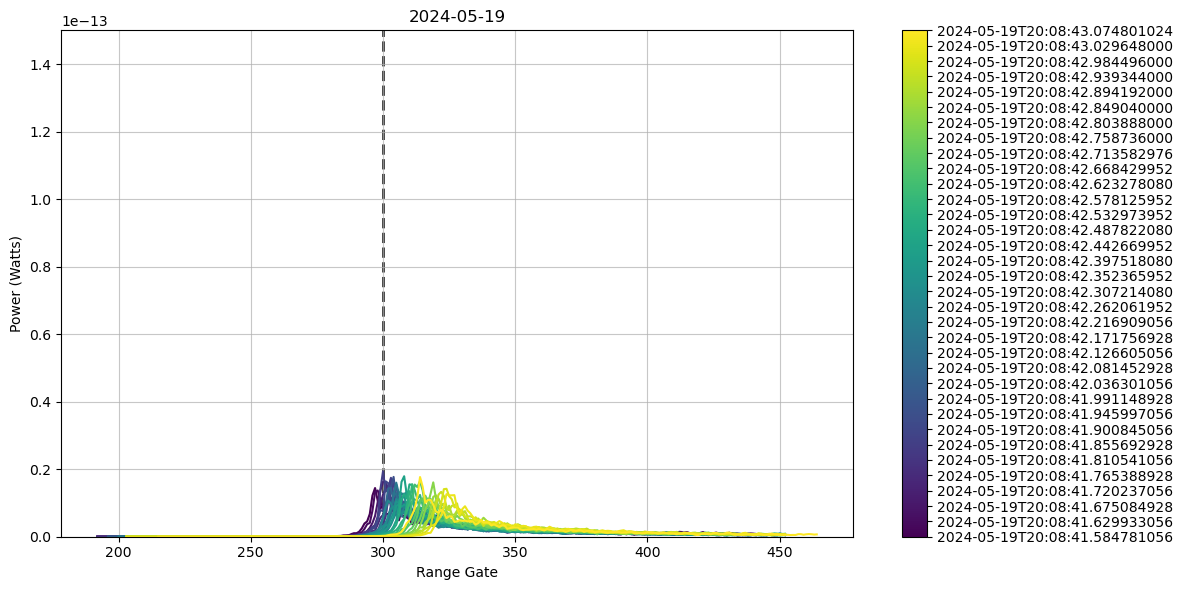

In [190]:
plot_wfm_rng_adjst(ds2_bbox, bin_start=200, bin_end=450, ylim=1.5e-13)
plt.savefig('thick_20240519_rng_shft.png')

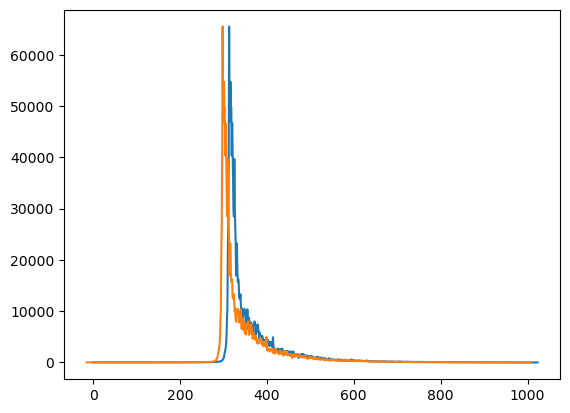

In [136]:
# plt.plot(ds1_bbox["pwr_waveform_20_ku"][1,:])# - rng_shft
# plt.plot(ds1_bbox["pwr_waveform_20_ku"][1]["ns_20_ku"] + rng_shft[1], ds1_bbox["pwr_waveform_20_ku"][1,:])# - rng_shft
ii=29
bin_n = ds1_bbox["pwr_waveform_20_ku"][ii]["ns_20_ku"]

plt.plot(bin_n, ds1_bbox["pwr_waveform_20_ku"][ii,:])# - rng_shft
plt.plot(bin_n + rng_shft[ii], ds1_bbox["pwr_waveform_20_ku"][ii,:])# - rng_shft


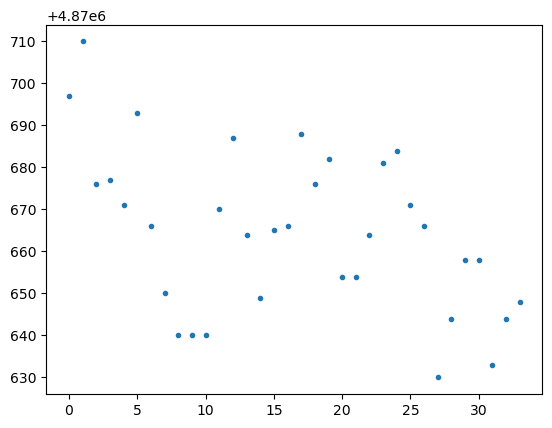

In [43]:
# plt.plot(ds1_bbox["window_del_20_ku"], '.')
# plt.plot(ds1_bbox["h0_fai_word_20_ku"], '.')
# plt.plot(ds1_bbox["h0_lai_word_20_ku"], '.')
# plt.plot(ds1_bbox["h0_lai_word_20_ku"] - ds1_bbox["h0_applied_20_ku"], '.')
plt.plot(ds1_bbox["h0_applied_20_ku"], '.')


--------- Redundant old script follows ---------

plot_wfm_mean(ds1_bbox, bin_start=270, bin_end=450)


ds2_bbox_test = ds2_bbox.where(ds2_bbox.rec_count_20_ku==ds2.rec_count_20_ku.values.min()+94, drop=True) 

# for i in range(3):
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1x3 grid

for i, ax in enumerate(axes.flat):
    # plot_wfm(ds2_bbox, i, bin_start=270, bin_end=450, ax=ax)
    plot_wfm(ds2_bbox, i, bin_start=230, bin_end=410, ax=ax)
# plt.plot(ds2_bbox_test.pwr_waveform_20_ku[0, :])

# Thin 
n_to_plot = len(ds1_bbox.rec_count_20_ku)
ylim = 1.5e-12#10e-13
for i in range(n_to_plot):
    j = n_to_plot - i - 1
    fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 
    plot_wfm(ds1_bbox, i, bin_start=270, bin_end=450, ylim = ylim, ax=axes[0])
    plot_wfm(ds2_bbox, j, bin_start=230, bin_end=410, ylim = ylim, ax=axes[1])
    plt.savefig(f"wfm_fig{i}.png")
plt.close('all')


# Thick 
n_to_plot = len(ds1_bbox.rec_count_20_ku)

for i in range(n_to_plot):
    j = n_to_plot - i - 1
    fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 
    plot_wfm(ds1_bbox, i, bin_start=270, bin_end=450, ylim = 1e-13, ax=axes[0])
    plot_wfm(ds2_bbox, j, bin_start=270, bin_end=450, ylim = 1e-13, ax=axes[1])
    plt.savefig(f"wfm_fig{i}.png")


# Individual plots
n_to_plot = len(ds1_bbox.rec_count_20_ku)
# fig, axs = plt.subplots(n_to_plot, 2, figsize=(12, 2.5 * n_to_plot), sharex=True, sharey=True)

# Plot each waveform pair
for i in range(n_to_plot):
    # axs[i, 0] = plot_wfm(ds1_bbox, i, bin_start=270, bin_end=450) #.plot_wfm(ns, waveforms1[i], color="blue")
    axs[i, 1] = plot_wfm(ds1_bbox, i, bin_start=270, bin_end=450)
    # axs[i, 1] = plot_wfm(ds2_bbox, i, bin_start=270, bin_end=450)
    # axs[i, 1] = plot_wfm(ds2_bbox, i, bin_start=230, bin_end=410) # Thin case 20240522
    plt.savefig(f"wfm_fig{i}.png")
#     axs[i, 0].set_ylabel("Power")
#     axs[i, 0].set_title(f"Lat {lats1[i]:.4f}, Lon {lons1[i]:.4f}")
#     axs[i, 1].set_title(f"Lat {lats2[i]:.4f}, Lon {lons2[i]:.4f}")

# # Label x-axis of bottom row
# for ax in axs[-1, :]:
#     ax.set_xlabel("ns_20_ku (Bin Index)")

# # Add column titles
# fig.text(0.26, 0.95, "20240406", fontsize=14, fontweight='bold', ha='center')
# fig.text(0.74, 0.95, "20240519", fontsize=14, fontweight='bold', ha='center')

# plt.tight_layout(rect=[0, 0, 1, 0.93])  # leave space for top text
# plt.savefig("thick.pdf")
# plt.show()

plt.close('all')